In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

combined_features_path = '/content/drive/My Drive/Data/c_features.pkl'
y_df_path = '/content/drive/My Drive/Data/c_target.pkl'

Mounted at /content/drive


In [3]:
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def calculate_log_loss(actual, forecast):
    return np.mean((np.log(actual / forecast))**2)

In [4]:
combined_features = pd.read_pickle(combined_features_path)
y_df = pd.read_pickle(y_df_path)

y = y_df.values.flatten()

combined_features = combined_features.loc[y_df.index]

splits = TimeSeriesSplit(n_splits=5)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
y_test_seq.shape: (96,), forecast.shape: (96,)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
y_test_seq.shape: (96,), forecast.shape: (96,)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
y_test_seq.shape: (96,), forecast.shape: (96,)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
y_test_seq.shape: (96,), forecast.shape: (96,)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
y_test_seq.shape: (96,), forecast.shape: (96,)
Average MAE: 15.493371081152977
Average MAPE: 31.513890418113597
Average Log Loss: 0.16071541845333728



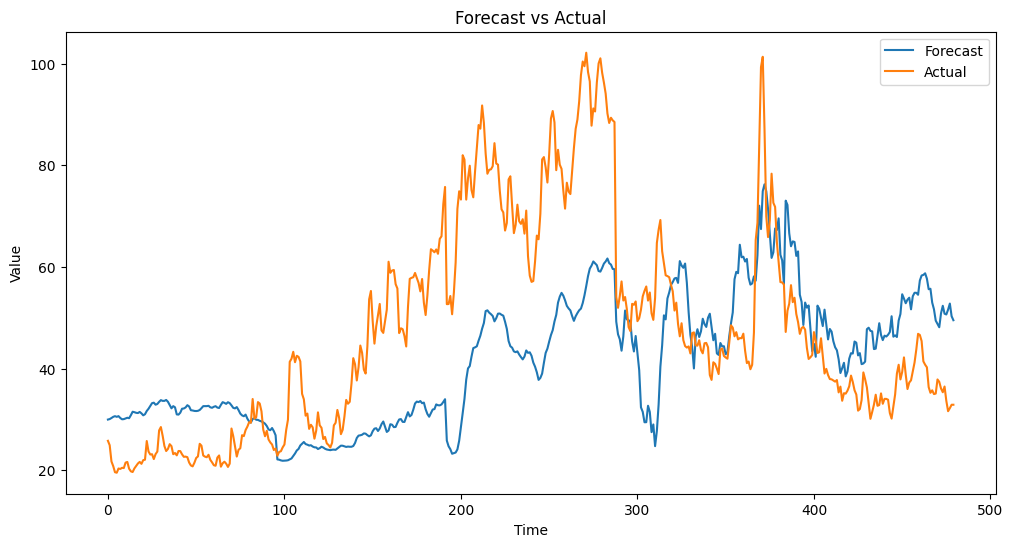

In [5]:
def create_sequences(X, y, time_steps=15):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

def preprocess_features(X):
    scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(X)
    X_scaled = minmax_scaler.fit_transform(X_scaled)

    X_scaled[np.isnan(X_scaled)] = 0
    X_scaled[np.isinf(X_scaled)] = 0

    return X_scaled

forecasts = []
forecast_indices = []
mae_scores = []
mape_scores = []
log_loss_scores = []

splits = TimeSeriesSplit(n_splits=5)
time_steps = 15

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

for train_idx, test_idx in splits.split(combined_features):
    X_train, X_test = combined_features.iloc[train_idx], combined_features.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    X_train_scaled = preprocess_features(X_train)
    X_test_scaled = preprocess_features(X_test)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

    X_train_seq_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
    X_test_seq_flat = X_test_seq.reshape(X_test_seq.shape[0], -1)

    grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring=scorer, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_seq_flat, y_train_seq)

    best_svr = grid_search.best_estimator_

    forecast = best_svr.predict(X_test_seq_flat)

    print(f"y_test_seq.shape: {y_test_seq.shape}, forecast.shape: {forecast.shape}")

    if len(y_test_seq) == len(forecast):
        forecasts.extend(forecast)
        forecast_indices.extend(test_idx[time_steps:])

        mae = mean_absolute_error(y_test_seq, forecast)
        mae_scores.append(mae)
        mape_scores.append(calculate_mape(y_test_seq, forecast))
        log_loss_scores.append(calculate_log_loss(y_test_seq, forecast))
    else:
        print("Warning: Length mismatch between y_test_seq and forecast")

average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
average_log_loss = np.mean(log_loss_scores)

print(f"Average MAE: {average_mae}")
print(f"Average MAPE: {average_mape}")
print(f"Average Log Loss: {average_log_loss}\n")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(forecasts, label='Forecast')
plt.plot(y[forecast_indices], label='Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()